In [2]:
import os

###Setup Depencencies

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Demo

In [4]:
MODEL_DIR = 'saved_models/'
MODEL_NAME = 'resnet18_attention_b16_emd300_best_val.pt'
# MODEL_NAME = 'resnet18_attention_b128_emd300_best_val.pt'

In [5]:
import os
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets.flickr8k import Flickr8kDataset
from metrics import *
from utils_torch import *
from utils_plot import visualize_att

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
DATASET_BASE_PATH = 'data/flickr8k/'

In [8]:
vocab_set = pickle.load(open(MODEL_DIR+'vocab_set.pkl', 'rb')) if os.path.exists(MODEL_DIR+'vocab_set.pkl') else None
vocab, word2idx, idx2word, max_len = vocab_set
vocab_size = len(vocab)
vocab_size, max_len

(7708, 40)

In [9]:
val_set = Flickr8kDataset(dataset_base_path=DATASET_BASE_PATH, dist='val', vocab_set=vocab_set, device=device,
                          return_type='corpus',
                          load_img_to_memory=False)
test_set = Flickr8kDataset(dataset_base_path=DATASET_BASE_PATH, dist='test', vocab_set=vocab_set, device=device,
                           return_type='corpus',
                           load_img_to_memory=False)
train_eval_set = Flickr8kDataset(dataset_base_path=DATASET_BASE_PATH, dist='train', vocab_set=vocab_set, device=device,
                                 return_type='corpus',
                                 load_img_to_memory=False)
len(train_eval_set), len(val_set), len(test_set)

(6000, 1000, 1000)

In [10]:
EMBEDDING_DIM = 300
ATTENTION_DIM = 256
DECODER_SIZE = 256
BATCH_SIZE = 16

In [11]:
checkpoint = torch.load(os.path.join(MODEL_DIR, MODEL_NAME))

In [12]:
def evaluate_model(data_loader, model, loss_fn, vocab_size, bleu_score_fn, tensor_to_word_fn, desc=''):
    running_bleu = [0.0] * 5
    model.eval()
    t = tqdm(iter(data_loader), desc=f'{desc}')
    for batch_idx, batch in enumerate(t):
        images, captions, lengths = batch
        outputs = tensor_to_word_fn(model.sample(images, startseq_idx=word2idx['<start>']).cpu().numpy())

        for i in (1, 2, 3, 4):
            running_bleu[i] += bleu_score_fn(reference_corpus=captions, candidate_corpus=outputs, n=i)
        t.set_postfix({
            'bleu1': running_bleu[1] / (batch_idx + 1),
            'bleu4': running_bleu[4] / (batch_idx + 1),
        }, refresh=True)
    for i in (1, 2, 3, 4):
        running_bleu[i] /= len(data_loader)
    return running_bleu

In [13]:
from models.torch.resnet18_attention import Captioner

final_model = Captioner(encoded_image_size=14, encoder_dim=512,
                        attention_dim=ATTENTION_DIM, embed_dim=EMBEDDING_DIM, decoder_dim=DECODER_SIZE,
                        vocab_size=vocab_size,).to(device)
final_model.load_state_dict(checkpoint['state_dict'])
final_model.eval()

Captioner(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [14]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=train_eval_set.pad_value).to(device)
sentence_bleu_score_fn = bleu_score_fn(4, 'sentence')
corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')
tensor_to_word_fn = words_from_tensors_fn(idx2word=idx2word)

eval_transformations = transforms.Compose([
    transforms.Resize(256),  # smaller edge of image resized to 256
    transforms.CenterCrop(256),  # get 256x256 crop from random location
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
])

val_set.transformations = eval_transformations
test_set.transformations = eval_transformations
train_eval_set.transformations = eval_transformations

In [15]:
eval_collate_fn = lambda batch: (torch.stack([x[0] for x in batch]), [x[1] for x in batch], [x[2] for x in batch])
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                        collate_fn=eval_collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                         collate_fn=eval_collate_fn)
train_eval_loader = DataLoader(train_eval_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                               collate_fn=eval_collate_fn)

In [16]:
model = final_model
model.eval()

Captioner(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [17]:
from scipy import ndimage
import skimage
import matplotlib.pyplot as plt

def visualize_att(image_path, seq, alphas, idx2word, endseq='<end>', smooth=False):
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)
    plt.imshow(image)

    words = [idx2word[idx] for idx in seq if idx2word[idx] != endseq]
    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(int(np.ceil(len(words) / 5.0)), 5, t + 1)  # Convert to integer
        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :].detach().cpu().numpy()
        alpha_img = skimage.transform.pyramid_expand(current_alpha, upscale=24, sigma=8)
        if smooth:
            alpha_img = ndimage.gaussian_filter(alpha_img, sigma=2)
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap('gray')
        plt.axis('off')
    plt.show()

References: ['A family gathered at a painted van', 'A girl climbing down from the side of a bright blue truck while others watch .', 'A man is helping a girl step down from a colorful truck whilst a woman and three children watch .', 'A very colorful bus is pulled off to the side of the road as its passengers load .', 'Two women and four children standing next to a brightly painted truck .']
pred: a group of people are standing in a park . 


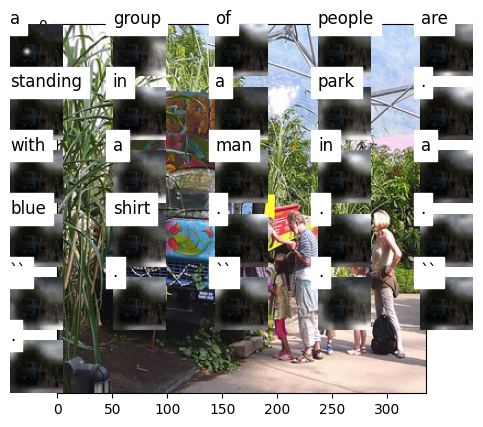

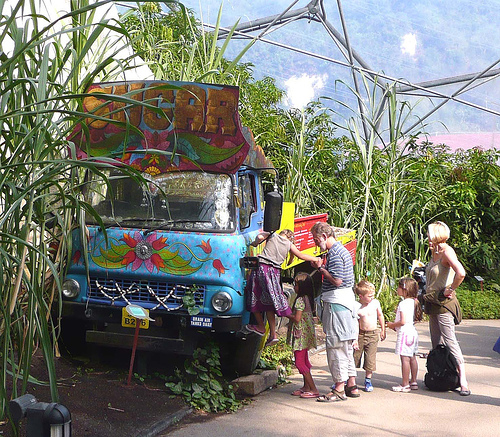

In [18]:
t_i = 103
dset = train_eval_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)



visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

References: ['A black dog shakes itself dry on the beach in front of the waves .', 'A dog is shaking itself dry on the beach next to the ocean .', 'A dog shaking off after coming out of the ocean .', 'dog shaking off water by the ocean', 'The dog is shaking off his fur in front of the water .']
pred: a black and white dog is running on the beach . 


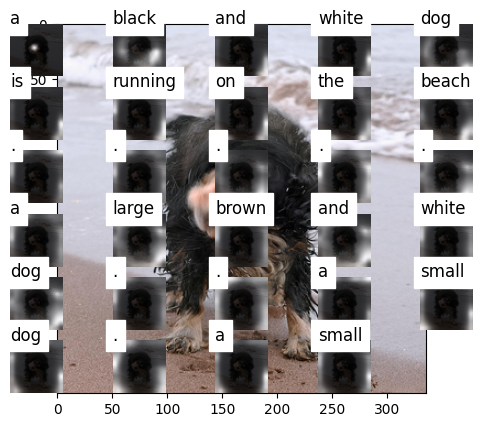

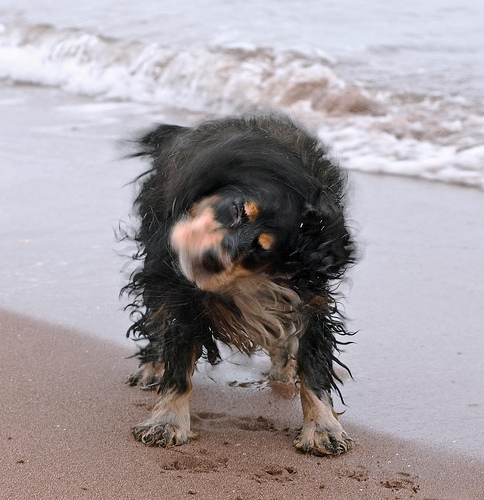

In [19]:
t_i = 503
dset = val_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

References: ['A woman holding onto a camera smiling at the camera .', 'A woman with a blue hat and blue and red jacket setting up a camera on a tripod .', 'A woman with a camera on a tripod is smiling for another camera .', 'People at a photo shoot .', 'The woman in blue is operating a camera in front of two other women .']
pred: a man and a woman are standing in front of a tree . 


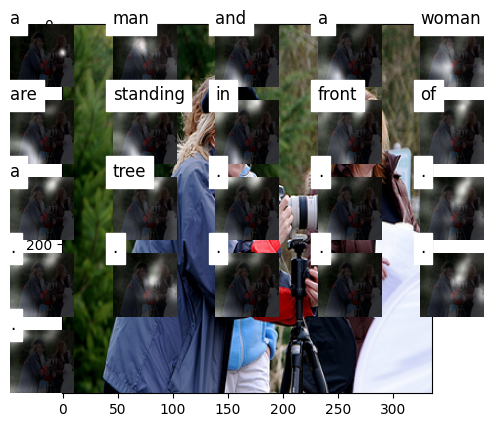

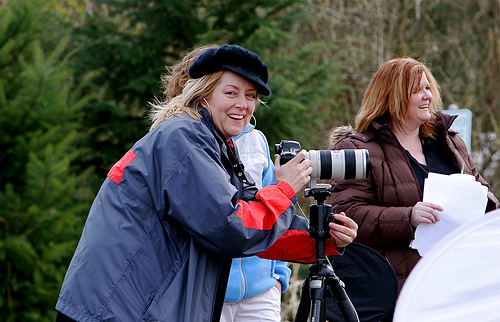

In [20]:
t_i = 205
dset = test_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

In [21]:
with torch.no_grad():
    model.eval()
    train_bleu = evaluate_model(desc=f'Train: ', model=final_model,
                                loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                                tensor_to_word_fn=tensor_to_word_fn,
                                data_loader=train_eval_loader, vocab_size=vocab_size)
    val_bleu = evaluate_model(desc=f'Val: ', model=final_model,
                              loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                              tensor_to_word_fn=tensor_to_word_fn,
                              data_loader=val_loader, vocab_size=vocab_size)
    test_bleu = evaluate_model(desc=f'Test: ', model=final_model,
                               loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                               tensor_to_word_fn=tensor_to_word_fn,
                               data_loader=test_loader, vocab_size=vocab_size)
    for setname, result in zip(('train', 'val', 'test'), (train_bleu, val_bleu, test_bleu)):
        print(setname, end=' ')
        for ngram in (1, 2, 3, 4):
            print(f'Bleu-{ngram}: {result[ngram]}', end=' ')
        print()

Train:   0%|          | 0/375 [00:00<?, ?it/s]

Val:   0%|          | 0/63 [00:00<?, ?it/s]

Test:   0%|          | 0/63 [00:00<?, ?it/s]

train Bleu-1: 0.5951125891278501 Bleu-2: 0.393334520946787 Bleu-3: 0.26307451315518554 Bleu-4: 0.1742287344722623 
val Bleu-1: 0.5694407361193793 Bleu-2: 0.3610743289529153 Bleu-3: 0.23079787908605592 Bleu-4: 0.14749943408480953 
test Bleu-1: 0.5735359305026727 Bleu-2: 0.36031147475841474 Bleu-3: 0.23037475667616297 Bleu-4: 0.14707305304942156 
